In [1]:
# !pip install piq

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms
import numpy as np

import matplotlib.pyplot as plt
import PIL
from tqdm import tqdm
from piq import SSIMLoss



# Load the data
f = np.load('celeba.npz')
imgs = f['imgs'].swapaxes(0, 2)  # Assuming images are in [H, W, N] format

In [ ]:
# Define LowPassFilter
class LowPassFilter(object):
    def __init__(self, cutoff_frequency):
        self.cutoff_frequency = cutoff_frequency

    def __call__(self, img):
        if isinstance(img, PIL.Image.Image):
            img = np.array(img)

        if len(img.shape) == 3:
            img = np.mean(img, axis=2)

        f_img = np.fft.fftshift(np.fft.fft2(img))

        rows, cols = img.shape
        crow, ccol = rows // 2, cols // 2
        mask = np.zeros((rows, cols), np.uint8)
        mask[crow-self.cutoff_frequency:crow+self.cutoff_frequency,
             ccol-self.cutoff_frequency:ccol+self.cutoff_frequency] = 1

        f_img_filtered = f_img * mask

        img_back = np.abs(np.fft.ifft2(np.fft.ifftshift(f_img_filtered)))
        img_back = (img_back - img_back.min()) / (img_back.max() - img_back.min())

        return PIL.Image.fromarray((img_back * 255).astype(np.uint8))

# Define transforms
low_pass_transform = transforms.Compose([
    transforms.ToPILImage(),
    LowPassFilter(cutoff_frequency=8),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

original_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

# Custom Dataset
class ImageDataset(Dataset):
    def __init__(self, imgs,labels):
        self.imgs = imgs
        self.labels = labels

    def __len__(self):
        return self.imgs.shape[0]

    def __getitem__(self, idx):
        img = self.imgs[idx, :, :]
        img_input = low_pass_transform(img)
        img_target = original_transform(img)
        return img_input, img_target, self.labels[idx]

# Initialize dataset
dataset = ImageDataset(imgs,f['labels'])
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# UNet model
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.enc1 = nn.Conv2d(1, 64, 3, padding=1)
        self.enc2 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2)

        # Decoder
        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = nn.Conv2d(256, 128, 3, padding=1)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = nn.Conv2d(128, 64, 3, padding=1)
        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = F.relu(self.enc1(x))
        e2 = F.relu(self.enc2(self.pool(e1)))
        e3 = F.relu(self.enc3(self.pool(e2)))

        d1 = F.relu(self.up1(e3))
        d1 = torch.cat([d1, e2], dim=1)
        d1 = F.relu(self.dec1(d1))

        d2 = F.relu(self.up2(d1))
        d2 = torch.cat([d2, e1], dim=1)
        d2 = F.relu(self.dec2(d2))

        return F.sigmoid(self.final(d2))

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)



In [ ]:
criterion = SSIMLoss(data_range = 1.0)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0
    for img_in, img_out,label in train_loader:
        img_in, img_out = img_in.to(device), img_out.to(device)

        optimizer.zero_grad()
        output = model(img_in)
        loss = criterion(output, img_out)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for img_in, img_out,label in val_loader:
            img_in, img_out = img_in.to(device), img_out.to(device)
            output = model(img_in)
            loss = criterion(output, img_out)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss/len(train_loader):.6f}, "
          f"Val Loss: {val_loss/len(val_loader):.6f}")

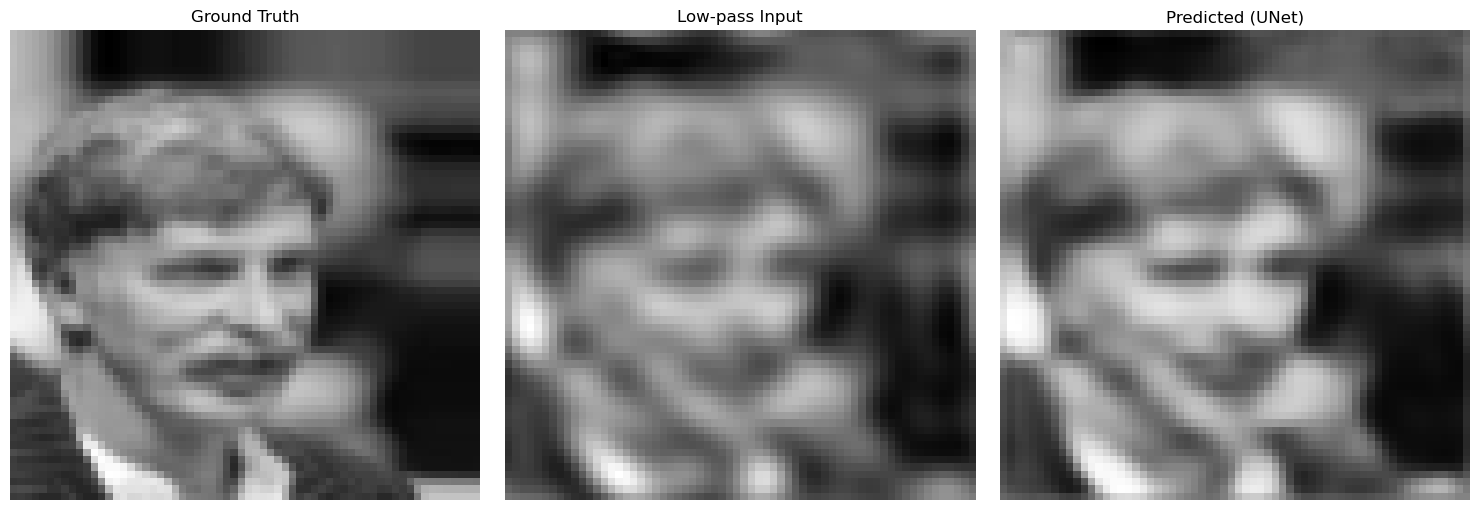

In [ ]:
# pick a random sample from validation dataset
idx = 1  # You can change this to visualize different images

# Get the low-pass filtered input image and ground truth from validation set
lowpass_img_tensor, ground_truth_tensor, label= train_dataset[idx]

# Move tensors to appropriate device (if GPU used in training)
device = next(model.parameters()).device
lowpass_img_tensor = lowpass_img_tensor.unsqueeze(0).to(device)

# Predict the high-frequency restored image from the low-pass image
with torch.no_grad():
    predicted_tensor = model(lowpass_img_tensor)

# Move predictions back to CPU and remove batch/channel dimensions
lowpass_img = lowpass_img_tensor.cpu().squeeze().numpy()
predicted_img = predicted_tensor.cpu().squeeze().numpy()
ground_truth_img = ground_truth_tensor.squeeze().numpy()

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(15,5))

axes[0].imshow(ground_truth_img, cmap='gray')
axes[0].set_title("Ground Truth")
axes[0].axis('off')

axes[1].imshow(lowpass_img, cmap='gray')
axes[1].set_title("Low-pass Input")
axes[1].axis('off')

axes[2].imshow(predicted_img, cmap='gray')
axes[2].set_title("Predicted (UNet)")
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [26]:
ssim_loss = SSIMLoss(data_range=1.0)

# Iterate through the dataset and calculate SSIM
ssim_values = []
ssim_values_pred = []

for img_in, img_out,label in val_loader:
    img_in, img_out = img_in.to(device), img_out.to(device)
    with torch.no_grad():
        img_pred = model(img_in)

    ssim = 1 - ssim_loss(img_in, img_out)  # SSIM = 1 - SSIMLoss
    ssim_pred = 1 - ssim_loss(img_in, img_pred)  # SSIM = 1 - SSIMLoss

    ssim_values.append(ssim.item())
    ssim_values_pred.append(ssim_pred.item())

# Calculate the average SSIM
average_ssim = sum(ssim_values) / len(ssim_values)
print(f"Average SSIM between input and output images: {average_ssim:.4f}")

average_ssim = sum(ssim_values_pred) / len(ssim_values_pred)
print(f"Average SSIM between input and pred images: {average_ssim:.4f}")

Average SSIM between input and output images: 0.7866
Average SSIM between input and pred images: 0.9185


In [27]:
# Classification network
class ClassificationNN(nn.Module):
    def __init__(self):
        super(ClassificationNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x  # raw logits

classification_model = ClassificationNN().to(device)
classification_model.load_state_dict(torch.load("classification_model.pth"))
classification_model.eval()

/var/tmp/ipykernel_1444828/1959297330.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classification_model.load_state_dict(torch.load("classification_model.pth"))


ClassificationNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [28]:
correct_input = 0
correct_output = 0
correct_predicted = 0
total = 0

classification_model.eval()

with torch.no_grad():
    for img_in, img_out, label in val_loader:
        img_in, img_out, label = img_in.to(device), img_out.to(device), label.to(device)

        # Classification on input images
        classification_output_input = classification_model(img_in)
        predicted_input = (torch.sigmoid(classification_output_input) > 0.5).float()
        correct_input += (predicted_input == label).sum().item()

        # Classification on output images
        classification_output_output = classification_model(img_out)
        predicted_output = (torch.sigmoid(classification_output_output) > 0.5).float()
        correct_output += (predicted_output == label).sum().item()

        # Classification on predicted images
        predicted_images = model(img_in)
        classification_output_predicted = classification_model(predicted_images)
        predicted_predicted = (torch.sigmoid(classification_output_predicted) > 0.5).float()
        correct_predicted += (predicted_predicted == label).sum().item()

        total += label.size(0)

accuracy_input = 100 * correct_input / total
accuracy_output = 100 * correct_output / total
accuracy_predicted = 100 * correct_predicted / total

print(f"Accuracy on Input Images: {accuracy_input:.2f}%")
print(f"Accuracy on Output Images: {accuracy_output:.2f}%")
print(f"Accuracy on Predicted Images: {accuracy_predicted:.2f}%")

Accuracy on Input Images: 86.33%
Accuracy on Output Images: 97.50%
Accuracy on Predicted Images: 90.50%
